In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [46]:
sns.set_style("darkgrid")

In [18]:
df = pd.read_csv("carer.csv", index_col=0)
df = df[df["split"] == 1]
df.head()

,text,emotions,split
333346,i dont feel resigned to my fate because i know...,4,1
333347,i am feeling very grouchy since i returned,0,1
333348,i still feel shaken,1,1
333349,i was feeling very lonely and wanting to get a...,4,1
333350,im not as frustrated and crabby like i used to...,0,1


In [19]:
from decks import load_carer

ds, _, _ = load_carer(512)

In [113]:
from decks.nets import metrics
from decks.nets.utils import text_encoder

def build_net(ds):
    outputs = 6
    h1, h2 = 45, 27

    enc = text_encoder(ds, None)
    model = tf.keras.Sequential(
        [
            enc,
            tf.keras.layers.Embedding(
                input_dim=len(enc.get_vocabulary()),
                output_dim=h1,
                mask_zero=True,
            ),
            tf.keras.layers.Bidirectional(tf.keras.layers.GRU(h1)),
            tf.keras.layers.Dense(h2, activation="relu"),
            tf.keras.layers.Dense(outputs, activation="softmax"),
        ]
    )
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            *[metrics.PrecisionForClass(x) for x in range(outputs)],
            *[metrics.RecallForClass(x) for x in range(outputs)],
            *[metrics.MccForClass(x) for x in range(outputs)],
        ],
    )
    return model


In [138]:
GEN = 3
EPOCHS = 100

In [141]:
from decks import DATA_DIR

net = build_net(ds)
# weights = tf.train.latest_checkpoint(DATA_DIR / "checkpoints/2001-0100-0512")
weights = DATA_DIR / f"checkpoints/200{GEN}-0100-0512/cp-{EPOCHS:>04}.ckpt"
net.load_weights(weights)
weights

PosixPath('/home/parafoxia/Programs/Projects/decks/data/checkpoints/2003-0100-0512/cp-0100.ckpt')

In [142]:
y_true = df["emotions"].values
y_score = net.predict(df["text"])
y_pred = np.argmax(y_score, axis=1)

1283/1283 [==============================] - 8s 5ms/step


In [143]:
acc = (np.count_nonzero(y_true == y_pred) / len(y_true)) * 100

tp, tn, fp, fn = 0, 0, 0, 0
pre, rec, mcc = [], [], []

for i in range(6):
    tp += np.count_nonzero((y_pred == i) & (y_true == i))
    tn += np.count_nonzero((y_pred != i) & (y_true != i))
    fp += np.count_nonzero((y_pred == i) & (y_true != i))
    fn += np.count_nonzero((y_pred != i) & (y_true == i))

    pre.append(tp / (tp + fp))
    rec.append(tp / (tp + fn))
    mcc.append((tp*tn - fp*fn) / (((tp+fn) * (tp+fp) * (tn+fp) * (tn+fn)) ** 0.5))

print(f"  ACC: {acc / 100:.3f}")
print(f"maPRE: {sum(pre) / len(pre):.3f}")
print(f"maREC: {sum(rec) / len(rec):.3f}")
print(f"maMCC: {sum(mcc) / len(mcc):.3f}")

  ACC: 0.891
maPRE: 0.898
maREC: 0.895
maMCC: 0.876


In [144]:
np.round(y_score[np.where(np.max(y_score, axis=1) == np.min(np.max(y_score, axis=1)))[0][0]], 3)

array([0.002, 0.329, 0.351, 0.   , 0.317, 0.   ], dtype=float32)

In [145]:
from sklearn import metrics as skmetrics
from sklearn.preprocessing import normalize

data = skmetrics.confusion_matrix(y_true, y_pred)
data = normalize(data, axis=1, norm="l1") * 100

Text(95.72222222222221, 0.5, 'True label')

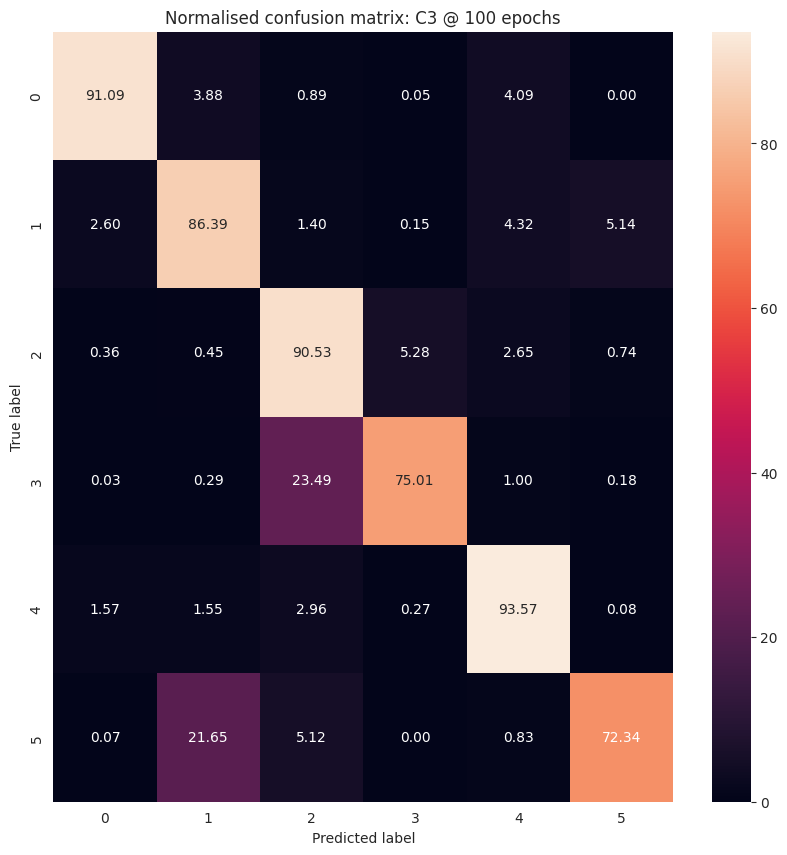

In [146]:
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=data, annot=True, fmt=".2f")
ax.set_title(f"Normalised confusion matrix: C{GEN} @ {EPOCHS} epochs")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

In [147]:
samples = (
    "I can't believe you just that!",
    "What was that noise?",
    "I can't contain my excitement!",
    "This is amazing!",
    "Everything just fucking sucks.",
    "Oh my god, you did that for me?",
)
arr = net.predict(np.array(samples))
np.round(arr, 3)

1/1 [==============================] - 2s 2s/step


array([[0.389, 0.289, 0.111, 0.006, 0.2  , 0.005],
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.956, 0.033, 0.009, 0.   , 0.002, 0.   ],
       [0.005, 0.029, 0.848, 0.007, 0.02 , 0.091],
       [0.672, 0.004, 0.061, 0.   , 0.262, 0.   ],
       [0.002, 0.112, 0.541, 0.002, 0.342, 0.   ]], dtype=float32)